<a href="https://colab.research.google.com/github/OptimoCX/BootCampIA/blob/main/rnn_text_blocks_tf_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Generación de **Texto** con RNN (TensorFlow/Keras)

**Propósito:** ver, paso a paso y sin funciones auxiliares, cómo entrenar una RNN para predecir el siguiente **carácter** y luego **generar** texto.


## 0) Setup

In [ ]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
np.random.seed(1)
print(np.random.randint(0, 10, size=5))  # siempre el mismo resultado

tf.random.set_seed(1)
print(tf.random.uniform((3,), minval=0, maxval=1))  # mismo vector en cada ejecución


[5 8 9 5 0]
tf.Tensor([0.16513085 0.9014813  0.6309742 ], shape=(3,), dtype=float32)



## 1) Corpus y vocabulario (carácter ↔ id)
- Convertimos texto a números porque las redes trabajan con tensores.


In [ ]:

corpus = (
    "Había una vez una red recurrente que aprendía patrones letra por letra. "
    "A veces repetía, a veces sorprendía. "
    "La temperatura en el muestreo controla la creatividad."
)

chars = sorted(list(set(corpus))) # oma todos los caracteres únicos que aparecen en corpus (incluyendo letras, espacios, saltos de línea, signos, etc.).
stoi  = {c:i for i,c in enumerate(chars)} # stoi (string to index) asigna un número único a cada carácter.
itos  = {i:c for c,i in stoi.items()} # itos (index to string) hace la conversión inversa, para reconstruir texto a partir de IDs.
vocab_size = len(stoi) #  cuántos caracteres únicos hay en el corpus.

data_ids = np.array([stoi[c] for c in corpus], dtype=np.int32)

print("Vocabulario:", vocab_size)
print("Primeros 80 caracteres:", corpus[:80])
print("Primeros 30 ids:", data_ids[:30].tolist())


Vocabulario: 25
Primeros 80 caracteres: Había una vez una red recurrente que aprendía patrones letra por letra. A veces 
Primeros 30 ids: [4, 6, 7, 24, 6, 0, 21, 14, 6, 0, 22, 10, 23, 0, 21, 14, 6, 0, 18, 10, 9, 0, 18, 10, 8, 21, 18, 18, 10, 14]



## 2) Ventanas de entrenamiento (contexto fijo → próximo carácter)
- `seq_len` es cuántos caracteres ve el modelo antes de predecir el siguiente.


In [ ]:

seq_len = 40 #  cada muestra (X) tendrá 40 caracteres (o IDs de caracteres) como contexto.
# Esto determina cuánta “historia” previa verá el modelo para predecir lo siguiente.

X_list, Y_list = [], []

#X_list, guardará las secuencias de entrada (contexto).
#Y_list ,  guardará las secuencias objetivo (lo que el modelo debe predecir).

for i in range(len(data_ids) - seq_len):
    X_list.append(data_ids[i:i+seq_len])         # contexto
    Y_list.append(data_ids[i+1:i+seq_len+1])     # objetivo (shift +1)

X = np.array(X_list, dtype=np.int32) # Convierte las listas a arrays NumPy para que sean procesables por TensorFlow.
Y = np.array(Y_list, dtype=np.int32)

print("Formas → X:", X.shape, "| Y:", Y.shape)

# Ejemplo
ej_x = "".join([itos[int(i)] for i in X[0][:50]])
ej_y = "".join([itos[int(i)] for i in Y[0][:50]])
print("\nEjemplo X:", ej_x)
print("Ejemplo Y:", ej_y). # Sirve para verificar visualmente que Y está correctamente desplazada respecto a


Formas → X: (123, 40) | Y: (123, 40)

Ejemplo X: Había una vez una red recurrente que apr
Ejemplo Y: abía una vez una red recurrente que apre


# **TEACHER FORCING:**


Esto es lo que en aprendizaje de modelos de lenguaje se llama teacher forcing: en cada paso le das al modelo la secuencia real hasta ese punto para que prediga el siguiente carácter.

## 3) Dataset (train/val)

In [ ]:

split = int(0.9*len(X)) # Toma el 90% de las muestras (X) para entrenamiento y el 10% restante para validación.
batch_size = 64 # Batches más grandes pueden ser más rápidos, pero usan más memoria.

ds_train = tf.data.Dataset.from_tensor_slices((X[:split], Y[:split])).shuffle(8000).batch(batch_size).prefetch(tf.data.AUTOTUNE) # Mezcla aleatoriamente las muestras para que el modelo no aprenda patrones artificiales por el orden del corpus.
ds_val   = tf.data.Dataset.from_tensor_slices((X[split:], Y[split:])).batch(batch_size).prefetch(tf.data.AUTOTUNE) # AUTOTUNE deja que TensorFlow decida el número óptimo de batches que preparar por adelantado.



## 4) Modelo RNN sencillo
- Puedes cambiar `SimpleRNN` ↔ `GRU` ↔ `LSTM` y comparar.


In [ ]:

model_type = "lstm"   # "rnn" | "gru" | "lstm". #definir qué arquitectura recurrente usar.

RNN = {
    "rnn":  tf.keras.layers.SimpleRNN,
    "gru":  tf.keras.layers.GRU,
    "lstm": tf.keras.layers.LSTM
}[model_type]

text_model = tf.keras.Sequential([
     #Entrada: tensores de enteros (batch_size, seq_len) donde cada entero es el ID de un carácter (por ejemplo, 17 para "a", 5 para " ").
     #Salida: tensores (batch_size, seq_len, 32) donde cada entero se reemplaza por un vector de 32 valores flotantes que el modelo aprende durante el entrenamiento.
    tf.keras.layers.Embedding(vocab_size, 32, input_length=seq_len),
    RNN(64, return_sequences=True),
    tf.keras.layers.Dense(vocab_size)   # logits por paso
])

text_model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
text_model.build(input_shape=(None, seq_len))
text_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 40, 32)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 40, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40, 25)         │         1,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,257 (106.47 KB)

 Trainable params: 27,257 (106.47 KB)

 Non-trainable params: 0 (0.00 B)

## 5) Entrenamiento

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4014 - sparse_categorical_accuracy: 0.9354 - val_loss: 1.8620 - val_sparse_categorical_accuracy: 0.5788
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3865 - sparse_categorical_accuracy: 0.9364 - val_loss: 1.8396 - val_sparse_categorical_accuracy: 0.5904
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3850 - sparse_categorical_accuracy: 0.9341 - val_loss: 1.8313 - val_sparse_categorical_accuracy: 0.5923
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3671 - sparse_categorical_accuracy: 0.9355 - val_loss: 1.8230 - val_sparse_categorical_accuracy: 0.5981
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3546 - sparse_categorical_accuracy: 0.9382 - val_loss: 1.8150 - val_sparse_categorical_accuracy: 0.6000
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3469 - sparse_categorical_accuracy: 0.9370 - val_loss: 1.7910 - val_sparse_categorical_accuracy: 0.6115
Epoch 7/100
2/2 

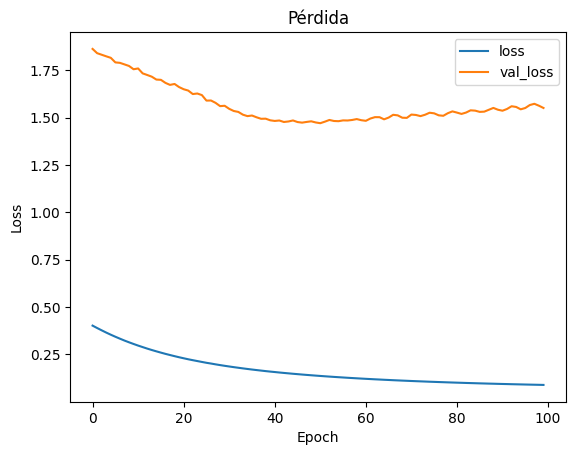

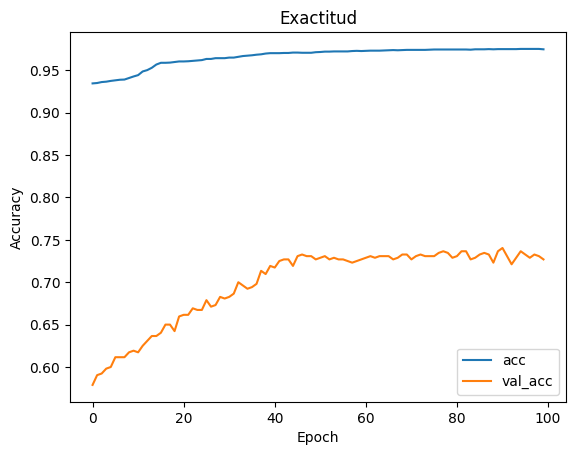

In [ ]:
epochs = 100
history = text_model.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1)

# Gráficas simples
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Pérdida')
plt.legend(); plt.show()

plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'], label='acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Exactitud')
plt.legend(); plt.show()


# Generación de Textos:

| Técnica     | Determinismo | Creatividad | Riesgo de incoherencia | Control sobre diversidad |
| ----------- | ------------ | ----------- | ---------------------- | ------------------------ |
| Greedy      | Alto         | Bajo        | Bajo                   | Ninguno                  |
| Temperatura | Variable     | Variable    | Variable               | Moderado (por temp)      |
| Top-k       | Bajo/Medio   | Medio       | Bajo/Medio             | Alto (por k)             |




Regla práctica:

1. Textos muy estructurados (código, instrucciones precisas) → Greedy o temperatura baja (0.6–0.8).
2. Textos creativos (poesía, storytelling) → Temperatura media (0.8–1.0) + top-k (20–50).
3. Exploración controlada → top-k + temperatura moderada para balancear calidad y variedad.


## 6) Generación **greedy**
- Siempre elige el carácter con probabilidad más alta (coherente pero repetitivo).

(greedy decoding) es una estrategia de generación de texto en la que, en cada paso, el modelo elige siempre el carácter con la probabilidad más alta (el logit más grande), sin explorar otras opciones.


In [ ]:

seed = "Había una "
max_new = 200

ids = [stoi.get(c, 0) for c in seed]   # convertimos semilla a ids

for _ in range(max_new):
    if len(ids) >= seq_len:
        window = ids[-seq_len:]
    else:
        window = [0]*(seq_len - len(ids)) + ids
    x = np.array(window, dtype=np.int32)[None, ...]       # (1, T)
    logits = text_model(x, training=False).numpy()[0, -1] # (V,)
    next_id = int(np.argmax(logits))                      # greedy
    ids.append(next_id)

generated_greedy = seed + "".join(itos[i] for i in ids[len(seed):])
print(generated_greedy)


Había una etra por letra. A veces repetía, a veces sorprendía. La temperatura en el muestreo controla la ltra letra por letra. A veces repetía, a veces sorprendía. La temperatura en el muestreo controla la ltra


🔹 Ventajas:

1. Rápido y sencillo: no requiere muestreo aleatorio ni parámetros extra.
2. Suele producir salidas gramaticalmente coherentes si el modelo está bien entrenado.

🔹 Desventajas:

1. Poca diversidad: tiende a generar repeticiones y frases muy predecibles.
2. Puede atascarse en bucles (ej. repetir “hola hola hola…”).
3. No explora posibilidades menos probables que podrían llevar a una mejor frase más adelante.


## 7) Generación con **temperatura**
Baja (0.7) = conservador; Alta (1.2) = más creativo/arriesgado.

temperature < 1 → afila la distribución (más determinista).

temperature > 1 → aplasta la distribución (más aleatoria/creativa).


In [ ]:

seed = "Una vez "
max_new = 200
temperature = 0.8

ids = [stoi.get(c, 0) for c in seed]

for _ in range(max_new):
    window = ids[-seq_len:] if len(ids) >= seq_len else [0]*(seq_len - len(ids)) + ids
    x = np.array(window, dtype=np.int32)[None, ...]
    logits = text_model(x, training=False).numpy()[0, -1]
    logits = logits / max(1e-6, temperature)
    probs = tf.nn.softmax(logits).numpy()
    next_id = int(np.random.choice(len(probs), p=probs))   # muestreo ponderado
    ids.append(next_id)

generated_temp = seed + "".join(itos[i] for i in ids[len(seed):])
print(generated_temp)


Una vez uetra por letra. A veces repetía, a veces sorprendía. La temperatura en el muestreo controla A letra oror eltemtura el mues letra. A veces repetía, a veces sorprendía. La temperatura en el muestreo co



## 8) Generación **top-k**
- Limita la elección a las `k` mejores opciones para evitar colas de probabilidad muy pequeñas.


In [ ]:

seed = "Érase "
max_new = 200
k = 5

ids = [stoi.get(c, 0) for c in seed]

for _ in range(max_new):
    window = ids[-seq_len:] if len(ids) >= seq_len else [0]*(seq_len - len(ids)) + ids
    x = np.array(window, dtype=np.int32)[None, ...]
    logits = text_model(x, training=False).numpy()[0, -1]

    top_idx = np.argpartition(logits, -k)[-k:]
    top_logits = logits[top_idx]
    probs = tf.nn.softmax(top_logits).numpy()
    pick_rel = int(np.random.choice(len(top_idx), p=probs))
    next_id = int(top_idx[pick_rel])

    ids.append(next_id)

generated_topk = seed + "".join(itos[i] for i in ids[len(seed):])
print(generated_topk)


Érase uura cets rpreldía. La temperatra e mues letría. A veces repetía, a veces sorprendía. La temperatura en el muestreo controla latra lerate atrores letra. A veces repetía, a veces sorprendía. La tempera
